### Preparing for time comparison

In [1]:
from time import time, sleep

start_time = time()

# Python code here
sleep(1)

end_time = time()

time_spent = end_time - start_time

print(time_spent)

import os
import psutil
 
# inner psutil function
def process_memory():
    process = psutil.Process(os.getpid())
    mem_info = process.memory_info()
    return mem_info.rss
 
# decorator function
def profile(func):
    def wrapper(*args, **kwargs):
        mem_before = process_memory()
        result = func(*args, **kwargs)
        mem_after = process_memory()
        print("{}:consumed memory: {} MB".format(
            func.__name__,
            (mem_after - mem_before) / (1024 ** 2))) 
        return result
    return wrapper

1.0103113651275635


### Preparing for memory usage comparison

In [9]:
import os
import psutil
 
# inner psutil function
def process_memory():
    process = psutil.Process(os.getpid())
    mem_info = process.memory_info()
    return mem_info.rss
 
# decorator function
def profile(func):
    def wrapper(*args, **kwargs):
        mem_before = process_memory()
        result = func(*args, **kwargs)
        mem_after = process_memory()
        print("{}:consumed memory: {} MB".format(
            func.__name__,
            (mem_after - mem_before) / (1024 ** 2))) 
        return result
    return wrapper
 
# instantiation of decorator function
@profile
# main code for which memory has to be monitored
def run_fastqc():
#     x = [1] * (10 ** 7)
    y = [2] * (4 * 10 ** 8)
#     del x
#     return y
 
run_fastqc()

run_fastqc:consumed memory: 0.0078125 MB


### 0. Installing libraries

In [ ]:
# !pip install Bio

- Searching for help

In [ ]:
help(PairwiseAligner)

### Sequence transformation and editing
- Biopython: https://academic.oup.com/bioinformatics/article/25/11/1422/330687

In [2]:
from Bio.Seq import Seq

In [3]:
start_time = time()

dna_seq = Seq('ATCGAG') # creating Seq object -> instance of class Seq

rna_seq = dna_seq.transcribe()
rev = dna_seq[::-1] # no built-in function for reverse
compl = dna_seq.complement()
rev_compl = dna_seq.reverse_complement()
protein_seq = dna_seq.translate()

print(rna_seq)
print(rev)
print(compl)
print(rev_compl)
print(protein_seq)

end_time = time()

time_spent = end_time - start_time

print(time_spent)

AUCGAG
GAGCTA
TAGCTC
CTCGAT
IE
0.001940011978149414


In [15]:
@profile
def seqTransfEdit():
    dna_seq = Seq('ATCGAG') # creating Seq object -> instance of class Seq

    rna_seq = dna_seq.transcribe()
    rev = dna_seq[::-1] # no built-in function for reverse
    compl = dna_seq.complement()
    rev_compl = dna_seq.reverse_complement()
    protein_seq = dna_seq.translate()

    print(rna_seq)
    print(rev)
    print(compl)
    print(rev_compl)
    print(protein_seq)

seqTransfEdit()

AUCGAG
GAGCTA
TAGCTC
CTCGAT
IE
seqTransfEdit:consumed memory: 0.0 MB


### I/O Functions
- Biopython: https://academic.oup.com/bioinformatics/article/25/11/1422/330687
- Read FASTA and FASTQ files

In [2]:
from Bio import SeqIO

In [3]:
@profile
def read_fast_files():
    path_to_fasta = r'path_to_data\Bioinformatics\FASTA_Files\leprae.fasta'
    path_to_fastq = r'path_to_data\Bioinformatics\FASTQ_Files\P7741_R1.fastq'

    my_fasta_seq = SeqIO.read(path_to_fasta, format='fasta')
    my_fastq_seqs = SeqIO.parse(path_to_fastq, format='fastq')

    print(my_fasta_seq)
    print(my_fastq_seqs)

start_time = time()
read_fast_files()
end_time = time()

time_spent = end_time - start_time

print(time_spent)

ID: NC_002677.1
Name: NC_002677.1
Description: NC_002677.1 Mycobacterium leprae TN, complete sequence
Number of features: 0
Seq('ATGTTTGTACCGCACGCCAAAAAGCCCGAAATTTACGAGAACCAGAGAGATACG...ACC')
read_fast_files:consumed memory: 1.83984375 MB
0.05168795585632324


### Basic Alignment
- Biopython: https://academic.oup.com/bioinformatics/article/25/11/1422/330687

In [2]:
from Bio.Align import PairwiseAligner

In [3]:
@profile
def run_alignment():
    aligner = PairwiseAligner()

    aligner.mode = 'global'
    aligner.match_score = 1
    aligner.mismatch_score = 0

    alignments = aligner.align(seqA='ACCGGT', seqB='ACGT')
    print(alignments.score)

start_time = time()
run_alignment()
end_time = time()

time_spent = end_time - start_time

print(time_spent)

4.0
run_alignment:consumed memory: 0.0234375 MB
0.0017070770263671875


### Downloading data from NCBI

- Mycobacterium ulcerans strain Agy99, complete sequence
    - Accession Number: NC_008611

In [2]:
from Bio import Entrez, SeqIO
Entrez.email = 'carlos.seiya16@gmail.com'

In [3]:
@profile
def download_NCBI():
    # getting data
    handle = Entrez.efetch(db='nucleotide', id='NC_008611', rettype='fasta')
    record = list(SeqIO.parse(handle, format='fasta'))[0]
    handle.close()

    # writing file
    output_path = r'path_to_data\Bioinformatics\Agy99_py.fasta'
    SeqIO.write(record, output_path, 'fasta')

start_time = time()
download_NCBI()
end_time = time()

time_spent = end_time - start_time

print(time_spent)

download_NCBI:consumed memory: 3.90234375 MB
3.703704357147217


### Downloading data from TCGA
- GDC API: https://docs.gdc.cancer.gov/API/Users_Guide/Getting_Started/
- Understanding barcodes: https://docs.gdc.cancer.gov/Encyclopedia/pages/TCGA_Barcode/

- Loading libraries

In [2]:
import pandas as pd
import requests
import json
import shutil
import os
import re

- Functions

In [3]:
def convert_response_df(response):
    lista_final = []
    lista_resposta = response.content.decode('utf-8').split('\r\n')
    for lista in list(map(lambda x:x.split('\t'), lista_resposta)):
        if '' not in lista:
            dic_temp = {}
            for i, element in enumerate(lista):
                dic_temp[i+1] = element
            lista_final.append(dic_temp)
    df = pd.DataFrame(lista_final)
    df.columns = df.iloc[0]
    df = df.iloc[1:].reset_index(drop=True)
    return df

def download_data_from_id(file_id):
    data_endpoint = f'https://api.gdc.cancer.gov/data/{file_id}'

    response = requests.get(data_endpoint,
                             headers = {'Content-Type': 'application/json'})

    response_head_cd = response.headers['Content-Disposition']

    file_name = re.findall('filename=(.+)', response_head_cd)[0]

    with open(file_name, 'wb') as output_file:
        output_file.write(response.content)

def create_directories(project_id, data_category, data_type):
    try:
        os.mkdir('GDCdata_Python')
        os.mkdir(f'GDCdata_Python/{project_id}')
        os.mkdir(f'GDCdata_Python/{project_id}/{data_category}')
        os.mkdir(f'GDCdata_Python/{project_id}/{data_category}/{data_type}')
    except:
        shutil.rmtree('GDCdata_Python')
        os.mkdir('GDCdata_Python')
        os.mkdir(f'GDCdata_Python/{project_id}')
        os.mkdir(f'GDCdata_Python/{project_id}/{data_category}')
        os.mkdir(f'GDCdata_Python/{project_id}/{data_category}/{data_type}') 

In [4]:
@profile
def download_TCGA():
    # querying (GDCquery)
    fields = [
        "access",
        # "analysis.input_files.platform",
        "analysis.workflow_type",
        "cases.samples.portions.analytes.aliquots.submitter_id",
        "cases.project.project_id",
        "cases.samples.sample_type",
        "data_category",
        "data_format",
        "data_type",
        "experimental_strategy",
        "file_name",
        "platform"
    ]

    fields = ','.join(fields)

    files_endpoint = 'https://api.gdc.cancer.gov/files'

    # filters
    project_id = 'TCGA-GBM'
    data_category = "DNA Methylation"
    data_type = "Methylation Beta Value"
    barcodes = ["TCGA-19-0962-01B-01D-0521-05", "TCGA-06-0137-01A-01D-0218-05"]

    filters = {
        'op': 'and',
        'content': [
        {
            'op': 'in',
            'content': {
                'field': 'cases.project.project_id',
                'value': [project_id]
            }
        },
        {
            "op": "in",
            "content":{
                "field": "data_category",
                "value": [data_category]
            }
        },
        {
            "op": "in",
            "content":{
                "field": "platform",
                "value": ["Illumina Human Methylation 27"]
            }
        },
        {
            "op": "in",
            "content":{
                "field": "access",
                "value": ["open"]
            }
        },
        {
            "op": "in",
            "content":{
                "field": "data_type",
                "value": [data_type]
            }
        },
        {
            "op": "in",
            "content":{
                "field": "cases.samples.portions.analytes.aliquots.submitter_id",
                "value": barcodes
            }
        },
    ]
    }

    params = {
        'filters': json.dumps(filters),
        'fields': fields,
        'format': 'TSV',
        'size': 10
    }

    response = requests.post(files_endpoint, headers = {"Content-Type": "application/json"}, json=params)

    # response processing
    response.content.decode("utf-8")
    df = convert_response_df(response)
#     display(df)
    id_list = list(df['id'].unique())
    ids = ','.join(id_list)
#     print(ids)

    create_directories(project_id, data_category, data_type)
    
    # downloading (GDCdownload)
    for current_id in id_list:

        # criar a pasta
        os.mkdir(f'GDCdata_Python/{project_id}/{data_category}/{data_type}/{current_id}')

        # baixar de fato
        download_data_from_id(current_id)
        filename = [file for file in os.listdir() if '.txt' in file][0].split('.txt')[0]

        # mover o arquivo
        shutil.move(f'{filename}.txt', f'GDCdata_Python/{project_id}/{data_category}/{data_type}/{current_id}')

start_time = time()
download_TCGA()
end_time = time()
time_spent = end_time - start_time
print(time_spent)

download_TCGA:consumed memory: 5.234375 MB
4.485174894332886


### Single-cell RNASeq integration

- scVI: https://www.nature.com/articles/s41587-019-0113-3

- Tempo de script: 07:10:52 - 5GB utilizadas

In [2]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import rc_context
import scvi
import scanpy as sc
import os

C:\Users\CS381220\AppData\Roaming\Python\Python39\site-packages\scvi\_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
C:\Users\CS381220\AppData\Roaming\Python\Python39\site-packages\scvi\_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


In [3]:
start_time = time()

files = os.listdir('dedif_data/')

#removing serum and C2 to keep number of cells down
files = [x for x in files if ('2i' in x or 'Dox' in x) and '_C1_' in x]
# files
days = dict(zip([x.split('_')[0] for x in files]
    ,[float(x.split('_')[1].replace('D','').replace('iPSC', '20')) for x in files]))

def pp(path):
    adata = sc.read_10x_h5(path)
    adata.var_names_make_unique()
    sc.pp.filter_cells(adata, min_genes=300)
    sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)
    upper_lim = np.quantile(adata.obs.n_genes_by_counts.values, .97)
    adata = adata[adata.obs.n_genes_by_counts < upper_lim]
    adata.obs['Day'] = path.split('/')[1].split('_')[1].replace('D','')
    adata.obs['Sample'] = path.split('/')[1].split('_')[0]
    return adata

datas = []
for file in files:
    datas.append(pp('dedif_data/' + file))
    
adata = sc.concat(datas, index_unique='_')
sc.pp.filter_genes(adata, min_cells = 100)
adata.layers['counts'] = adata.X.copy()
scvi.model.SCVI.setup_anndata(adata, layer = "counts",
                             categorical_covariate_keys=["Sample"],
                             continuous_covariate_keys=['total_counts'])
model = scvi.model.SCVI(adata)
model.train()
adata.obsm['X_scVI'] = model.get_latent_representation()
# adata.layers['scvi_normalized'] = model.get_normalized_expression(library_size=1e4)

sc.pp.neighbors(adata, use_rep='X_scVI')
sc.tl.umap(adata)

adata.obs['Day'] = adata.obs['Sample'].map(days)

# adata.obs

with rc_context({'figure.figsize': (8, 8)}):
    sc.pl.umap(adata, color='Day', s = 5)

end_time = time()

time_spent = end_time - start_time
print(time_spent)

['GSM3195648_D0_Dox_C1_gene_bc_mat.h5',
 'GSM3195650_D0.5_Dox_C1_gene_bc_mat.h5',
 'GSM3195652_D1_Dox_C1_gene_bc_mat.h5',
 'GSM3195654_D1.5_Dox_C1_gene_bc_mat.h5',
 'GSM3195656_D2_Dox_C1_gene_bc_mat.h5',
 'GSM3195658_D2.5_Dox_C1_gene_bc_mat.h5',
 'GSM3195660_D3_Dox_C1_gene_bc_mat.h5']

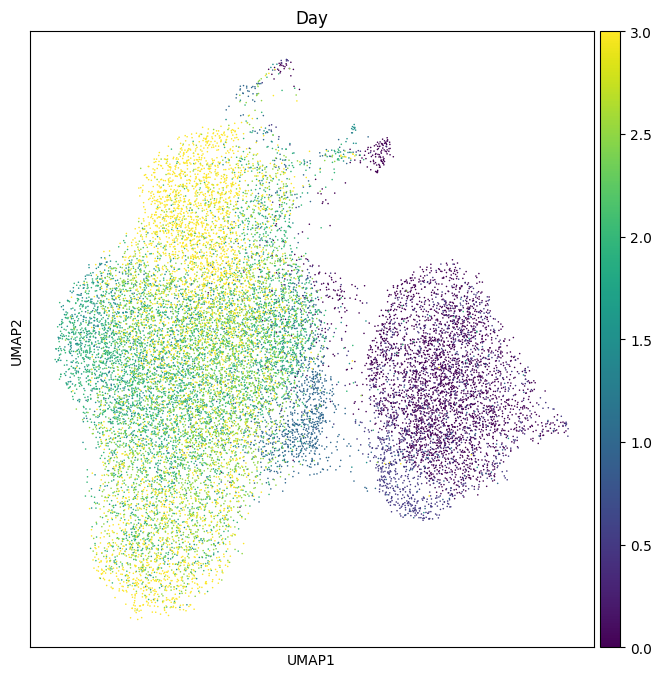

### Doublet Removals
- Data availability: https://0-www-ncbi-nlm-nih-gov.brum.beds.ac.uk/geo/query/acc.cgi?acc=GSM3195648
- scVI: https://www.nature.com/articles/s41592-018-0229-2
- scanpy: https://genomebiology.biomedcentral.com/articles/10.1186/s13059-017-1382-0


- Tempo de script: 00:12:39, 1,5 GB

In [26]:
# loading libraries
import scvi
import scanpy as sc
import pandas as pd

In [ ]:
# importing data
adata = sc.read_10x_h5('dedif_data/GSM3195648_D0_Dox_C1_gene_bc_mat.h5')
adata.var_names_make_unique()

# preprocessing: filtering + highly variable genes
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=10)
sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset=True, flavor='seurat_v3')

# training model for doublet removal (1)
scvi.model.SCVI.setup_anndata(adata)
vae = scvi.model.SCVI(adata)
vae.train()

# training model for doublet removal (2)
solo = scvi.external.SOLO.from_scvi_model(vae)
solo.train()

# predicting doublets
df = solo.predict()
df['prediction'] = solo.predict(soft=False)
df[df['prediction'] == 'doublet'] # identifying doublets
adata.obs['prediction'] = df['prediction']

# finishing preprocessing: normalizing, scaling, dimensionality reduction, clustering, non-linear dimensionality reduction
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution = 0.5)

# visualization
sc.pl.umap(adata, color=['leiden', 'prediction'])

doublet_d = dict(zip(df.index, df['prediction']))

def func(x):
    try:
        return doublet_d[x]
    except:
        return 'filtered'

adata = sc.read_10x_h5('dedif_data/GSM3195648_D0_Dox_C1_gene_bc_mat.h5')
adata.var_names_make_unique()
adata.obs['doublet'] = adata.obs.index.map(func)
adata = adata[adata.obs['doublet'] == 'singlet']
print(adata)

In [27]:
adata = sc.read_10x_h5('dedif_data/GSM3195648_D0_Dox_C1_gene_bc_mat.h5')

adata.var_names_make_unique()

C:\Users\CS381220\Anaconda3\lib\site-packages\anndata\_core\anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [28]:
adata

AnnData object with n_obs × n_vars = 3495 × 27998
    var: 'gene_ids'

In [29]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=10)
sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset=True, flavor='seurat_v3')

In [31]:
scvi.model.SCVI.setup_anndata(adata)

vae = scvi.model.SCVI(adata)

vae.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 400/400: 100%|█████| 400/400 [11:13<00:00,  1.71s/it, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.14e+3]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|█████| 400/400 [11:14<00:00,  1.69s/it, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.14e+3]


In [32]:
solo = scvi.external.SOLO.from_scvi_model(vae)

INFO     Creating doublets, preparing SOLO model.                                                                  


In [33]:
solo.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 367/400:  92%|████████▎| 367/400 [01:26<00:07,  4.25it/s, v_num=1, train_loss_step=0.182, train_loss_epoch=0.202]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.222. Signaling Trainer to stop.


In [47]:
df = solo.predict()
df['prediction'] = solo.predict(soft=False)
# df.index = df.index.map(lambda x: x[:-2])
df

,doublet,singlet,prediction
AAACCTGAGTATCTCG-1,-2.889439,2.180743,singlet
AAACCTGCAAGCGAGT-1,-0.614328,0.372118,singlet
AAACCTGGTCTCTTAT-1,-1.438918,1.192961,singlet
AAACCTGTCAACACTG-1,-1.000417,1.033124,singlet
AAACCTGTCGTTGCCT-1,-0.898572,0.879020,singlet
...,...,...,...
TTTGGTTGTTTGGGCC-1,-1.615157,1.833079,singlet
TTTGTCACACCGATAT-1,-1.968921,1.513594,singlet
TTTGTCAGTTGAACTC-1,-2.325477,2.886070,singlet
TTTGTCATCACGGTTA-1,-1.029295,1.273055,singlet


In [48]:
df[df['prediction'] == 'doublet']

,doublet,singlet,prediction
AAAGCAAAGGTGCAAC-1,0.523614,-0.386981,doublet
AAAGCAACAGTTCATG-1,0.401384,-0.713718,doublet
AAAGTAGGTCGCTTCT-1,0.881205,-1.095817,doublet
AACACGTAGTCTCAAC-1,0.449153,-0.548072,doublet
AACCATGAGCCTATGT-1,1.936609,-1.992681,doublet
...,...,...,...
TTGGAACCAGCTATTG-1,0.029536,-0.342651,doublet
TTGGCAACATTGCGGC-1,0.476481,-0.403408,doublet
TTTATGCTCGATCCCT-1,0.458329,-0.532918,doublet
TTTCCTCAGATGCCAG-1,1.254746,-1.147277,doublet


In [49]:
adata.obs['prediction'] = df['prediction']
adata.obs

,n_genes,_scvi_batch,_scvi_labels,prediction
AAACCTGAGTATCTCG-1,2357,0,0,singlet
AAACCTGCAAGCGAGT-1,2978,0,0,singlet
AAACCTGGTCTCTTAT-1,2100,0,0,singlet
AAACCTGTCAACACTG-1,3058,0,0,singlet
AAACCTGTCGTTGCCT-1,2609,0,0,singlet
...,...,...,...,...
TTTGGTTGTTTGGGCC-1,2350,0,0,singlet
TTTGTCACACCGATAT-1,1969,0,0,singlet
TTTGTCAGTTGAACTC-1,1872,0,0,singlet
TTTGTCATCACGGTTA-1,2054,0,0,singlet


In [50]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution = 0.5)

C:\Users\CS381220\Anaconda3\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\CS381220\Anaconda3\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


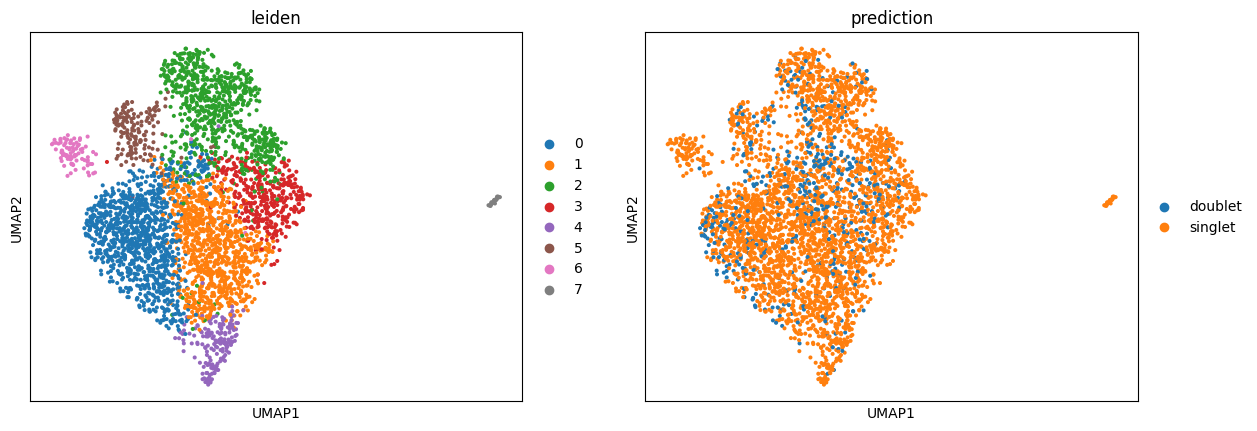

In [51]:
sc.pl.umap(adata, color=['leiden', 'prediction'])

In [52]:
df.head()

,doublet,singlet,prediction
AAACCTGAGTATCTCG-1,-2.889439,2.180743,singlet
AAACCTGCAAGCGAGT-1,-0.614328,0.372118,singlet
AAACCTGGTCTCTTAT-1,-1.438918,1.192961,singlet
AAACCTGTCAACACTG-1,-1.000417,1.033124,singlet
AAACCTGTCGTTGCCT-1,-0.898572,0.879020,singlet


In [53]:
doublet_d = dict(zip(df.index, df['prediction']))
doublet_d

{'AAACCTGAGTATCTCG-1': 'singlet',
 'AAACCTGCAAGCGAGT-1': 'singlet',
 'AAACCTGGTCTCTTAT-1': 'singlet',
 'AAACCTGTCAACACTG-1': 'singlet',
 'AAACCTGTCGTTGCCT-1': 'singlet',
 'AAACGGGAGAGGTTGC-1': 'singlet',
 'AAACGGGAGCGTAGTG-1': 'singlet',
 'AAACGGGAGTTGTAGA-1': 'singlet',
 'AAACGGGCAGCATACT-1': 'singlet',
 'AAACGGGGTATATGGA-1': 'singlet',
 'AAACGGGGTCAAGCGA-1': 'singlet',
 'AAACGGGTCGTCCAGG-1': 'singlet',
 'AAAGATGAGGCATTGG-1': 'singlet',
 'AAAGATGCAATCACAC-1': 'singlet',
 'AAAGATGGTTGAGGTG-1': 'singlet',
 'AAAGATGTCCCTTGCA-1': 'singlet',
 'AAAGATGTCTATCGCC-1': 'singlet',
 'AAAGCAAAGGTGCAAC-1': 'doublet',
 'AAAGCAACAGTTCATG-1': 'doublet',
 'AAAGCAAGTATATGAG-1': 'singlet',
 'AAAGCAATCTCGTATT-1': 'singlet',
 'AAAGTAGAGAATGTGT-1': 'singlet',
 'AAAGTAGGTCGCTTCT-1': 'doublet',
 'AAATGCCAGATCTGAA-1': 'singlet',
 'AAATGCCGTGAGCGAT-1': 'singlet',
 'AAATGCCTCAGAGACG-1': 'singlet',
 'AAATGCCTCCAGTAGT-1': 'singlet',
 'AAATGCCTCCGCGTTT-1': 'singlet',
 'AAATGCCTCGACAGCC-1': 'singlet',
 'AACACGTAGTCT

In [54]:
def func(x):
    try:
        return doublet_d[x]
    except:
        return 'filtered'

In [55]:
adata = sc.read_10x_h5('dedif_data/GSM3195648_D0_Dox_C1_gene_bc_mat.h5')
adata.var_names_make_unique()
adata.obs

C:\Users\CS381220\Anaconda3\lib\site-packages\anndata\_core\anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


""
AAACCTGAGTATCTCG-1
AAACCTGCAAGCGAGT-1
AAACCTGGTCTCTTAT-1
AAACCTGTCAACACTG-1
AAACCTGTCGTTGCCT-1
...
TTTGGTTGTTTGGGCC-1
TTTGTCACACCGATAT-1
TTTGTCAGTTGAACTC-1
TTTGTCATCACGGTTA-1


In [56]:
adata.obs['doublet'] = adata.obs.index.map(func)
adata.obs

,doublet
AAACCTGAGTATCTCG-1,singlet
AAACCTGCAAGCGAGT-1,singlet
AAACCTGGTCTCTTAT-1,singlet
AAACCTGTCAACACTG-1,singlet
AAACCTGTCGTTGCCT-1,singlet
...,...
TTTGGTTGTTTGGGCC-1,singlet
TTTGTCACACCGATAT-1,singlet
TTTGTCAGTTGAACTC-1,singlet
TTTGTCATCACGGTTA-1,singlet


In [57]:
adata = adata[adata.obs['doublet'] == 'singlet']
adata

View of AnnData object with n_obs × n_vars = 2972 × 27998
    obs: 'doublet'
    var: 'gene_ids'